In this notebook, we will explore Gaussian Process Machine Learning model for the methanol dataset.  The hold-out set containing three electrophiles of 1H-indol-5-yl N,N-dimethylsulfamate, Ethyl 4-chloro-3-fluorobenzoate, and Clofibrate will be used as the external electrophile testing set. We selected gpytorch python package as our GP model framework. 

# GP Model for Nickel Catalyzed Borylation in MeOH

### Load libraries

In [1]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import torch
import gpytorch

### Load Preprocessed Ethanol Dataset

In [2]:
dataset = pd.read_csv("./data/data_MeOH_Final.csv")
dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,50.731606,50.731606,351.19888,1.840787,-0.055960,A-paPhos,InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",88.86
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,80.673770,61.935337,479.46484,1.803143,-0.058457,CX-FBu,InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",54.07
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,107.755370,56.694310,386.44120,1.805810,-0.058387,CX-PCy,InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-1...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",74.99
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,117.597336,54.091050,618.03375,1.817123,-0.054418,Cy-BippyPhos,InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",82.92
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,111.484024,57.033180,402.37967,1.816461,-0.061351,Cy-JohnPhos,InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/CH4O/c1-2/h2H,1H3",80.25


In [3]:
dataset.shape

(779, 163)

### Prepare Hold-out Electrophiles Testing Set

Three electrophiles of 1H-indol-5-yl N,N-dimethylsulfamate, Ethyl 4-chloro-3-fluorobenzoate, and Clofibrate and their corresponding features will be set aside from the current dataset containing a total list of 34 unique electrophiles.

In [4]:
#Unique electrophiles
dataset.Electrophile.unique().tolist()

['1H-indol-5-yl\xa0N,N-dimethylsulfamate',
 "2-bromo-1,1'-biphenyl",
 '2-Chloro-5-fluorotoluene',
 '2-Chloro-m-xylene',
 '(2-Methyl-1,3-benzothiazol-5-yl)\xa0N,N-dimethylsulfamate',
 '3-Bromothiophene',
 '3-Chloro-2-methylaniline',
 '4-Bromoanisole',
 '4-Bromobenzotrifluoride',
 '4-Chloro-N,N-dimethylbenzamide',
 '5-chloroindole',
 'BMS-929356',
 'Ethyl\xa04-chloro-3-fluorobenzoate',
 'methyl\xa04-bromobenzoate',
 'quinolin-6-yl dimethylsulfamate',
 '3-Bromoquinoline',
 '3-bromo-2-methylpyridine',
 'Clofibrate',
 '4-Bromo-2-fluoroanisole',
 '4-Bromo-2-fluorobenzonitrile',
 '(4-Phenylphenyl) N,N-dimethylsulfamate',
 '4-Bromo-1,2-(methylenedioxy)benzene',
 '5-Bromobenzofuran',
 '4-chloro-1-fluoro-2-methoxybenzene',
 '4-chlorobenzotrifluoride',
 '3-chloroquinoline',
 '5-bromo-2,4-dimethoxypyrimidine',
 'methyl\xa04-chlorobenzoate',
 '5-Chloro-1,3-benzodioxole',
 '4-chloro-2-fluoro-1-methoxybenzene',
 '4-Chloro-2-fluoroanisole',
 '4-Chlorobiphenyl',
 '4-Bromobiphenyl',
 '4-Chloro-2-fluorob

In [5]:
#Twenty three unique Ligands here excluding MeO-KITPHOS due to the lack of Kraken parameters
dataset.Ligand.unique().tolist()

['A-paPhos',
 'CX-FBu',
 'CX-PCy',
 'Cy-BippyPhos',
 'Cy-JohnPhos',
 'Cy-PhenCar-Phos',
 'Cy-vBRIDP',
 'Kwong',
 'MePhos',
 'PCy3 HBF4',
 'Ph-DavePhos',
 'Ph-SPhos',
 'Ph-XPhos',
 'PMe3 HBF4',
 'PnBu3 HBF4',
 'P(o-Anis)3',
 'P(p-Anis)3',
 'P(p-F-Ph)3',
 'PPh2Cy',
 'PPh3',
 'PPhtBu2',
 'PXy3',
 'VPhos']

In [6]:
#Retrieve the three electrophiles and store the features in a separate dataframe 
indices=[0,12,17]
mapped = map(dataset.Electrophile.unique().tolist().__getitem__, indices)
external_list = list(mapped)
ML_data_validation = dataset[dataset['Electrophile'].isin(external_list)]
ML_data_validation2 = ML_data_validation.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_validation2.shape)
ML_data_validation2.head()

(69, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,88.86
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,54.07
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,74.99
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,82.92
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,80.25


In [7]:
#Keep the rest of the dataset for model training purpose 
exclude_list = ML_data_validation.index.values.tolist()
ML_data_traintest = dataset[~dataset.index.isin(exclude_list)]
ML_data_traintest2 = ML_data_traintest.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_traintest2.shape)
ML_data_traintest2.head()

(710, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
23,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,48.175
24,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,22.925
25,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,70.335
26,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,73.775
27,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,55.420


In a separate notebook, we have explored the cross-validation using a skorch package containing the scikit-learn compatible library wrapping the pytorch. The predicted results from the hold-out set was unsatisfactory.  In this example case, we treated all the normalized training dataset in the Gaussian Process base model. 

### Normalize Training set to unit scale with min-max function 

In [8]:
# Response target are all adjusted between 0~1
y_train = ML_data_traintest2['Yield']/100

#Normalize the input predictors to unit scale
Data_X = ML_data_traintest2.drop(columns=['Yield'])

#Transform the training set
sc = MinMaxScaler()
X_train = sc.fit_transform(Data_X)

#convert to torch from numpy
train_x = torch.from_numpy(np.array(X_train)).float()
train_y = torch.from_numpy(np.array(y_train)).float().view(-1)

In [9]:
# Gaussian process model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if len(train_x) > 0:
            dims = len(train_x[0])
        else:
            dims = 0
        kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=dims)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [11]:
model.likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-5))

In [12]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
            {'params': model.parameters()},], 
            lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (i + 1, training_iter, loss.item(), model.likelihood.noise.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.038  noise: 0.693
Iter 2/50 - Loss: 1.012  noise: 0.668
Iter 3/50 - Loss: 0.987  noise: 0.644
Iter 4/50 - Loss: 0.963  noise: 0.621
Iter 5/50 - Loss: 0.939  noise: 0.598
Iter 6/50 - Loss: 0.916  noise: 0.576
Iter 7/50 - Loss: 0.893  noise: 0.554
Iter 8/50 - Loss: 0.871  noise: 0.533
Iter 9/50 - Loss: 0.848  noise: 0.512
Iter 10/50 - Loss: 0.826  noise: 0.492
Iter 11/50 - Loss: 0.804  noise: 0.473
Iter 12/50 - Loss: 0.783  noise: 0.454
Iter 13/50 - Loss: 0.760  noise: 0.436
Iter 14/50 - Loss: 0.738  noise: 0.418
Iter 15/50 - Loss: 0.716  noise: 0.401
Iter 16/50 - Loss: 0.693  noise: 0.384
Iter 17/50 - Loss: 0.671  noise: 0.368
Iter 18/50 - Loss: 0.648  noise: 0.353
Iter 19/50 - Loss: 0.625  noise: 0.338
Iter 20/50 - Loss: 0.602  noise: 0.323
Iter 21/50 - Loss: 0.578  noise: 0.309
Iter 22/50 - Loss: 0.555  noise: 0.295
Iter 23/50 - Loss: 0.532  noise: 0.282
Iter 24/50 - Loss: 0.509  noise: 0.270
Iter 25/50 - Loss: 0.485  noise: 0.257
Iter 26/50 - Loss: 0.462  noise: 0

In [13]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
     train_pred = likelihood(model(train_x))

/opt/conda/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [14]:
#Check Top 50 Features by Lengthscale
ls = pd.Series(model.covar_module.base_kernel.lengthscale.detach().numpy()[0], 
               index=Data_X.columns.values, 
               name='l').sort_values()
ls.head(50)

ArylHalide_C_Chem Shift                    1.805689
ArylHalide_XY_Chem Shift_Min               1.951357
ArylHalide_XY_Natural_Min                  1.964570
ArylHalide_XY_Mulliken_Min                 1.970344
ArylHalide_XY_Lowdin_Avg                   1.991312
ArylHalide_X_Electrostatic                 2.066571
ArylHalide_XY_Electrostatic_Min            2.074663
ArylHalide_XY_Mulliken_Bond_Avg            2.088258
ArylHalide_C_Electrostatic                 2.102612
ArylHalide_CX_Lowdin                       2.102989
ArylHalide_XY_Chem Shift_Max               2.123598
ArylHalide_XY_Length_Max                   2.139085
ArylHalide_XY_Length_Min                   2.172330
ArylHalide_XY_Mulliken_Bond_Max            2.178922
ArylHalide_XY_Exposed Area_Avg             2.201536
ArylHalide_XY_Lowdin_Max                   2.204232
ArylHalide_XY_Mulliken_Bond_Min            2.218052
ArylHalide_XY_Electrostatic_Max            2.218495
ArylHalide_XY_Lowdin_Min                   2.219734
ArylHalide_C

### Hold-out Electrophiles Testing set Evaluation

In [15]:
#Apply the same unit scale normalization 
ext_y=ML_data_validation2['Yield']/100
ext_X=ML_data_validation2.iloc[:, ML_data_validation2.columns.isin(Data_X.columns)]
X_ext_transformed = sc.transform(ext_X)
external_x = torch.from_numpy(np.array(X_ext_transformed)).float()
external_y = torch.from_numpy(np.array(ext_y)).float().view(-1)

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
     pred = likelihood(model(external_x))
     # Get upper and lower confidence bounds; Returns 2 standard deviations above and below the mean
     lower, upper = pred.confidence_region()

### Plot Parity Plot

Just to keep the consistent names in the paper, we will label this external hold-out set as the validation set.

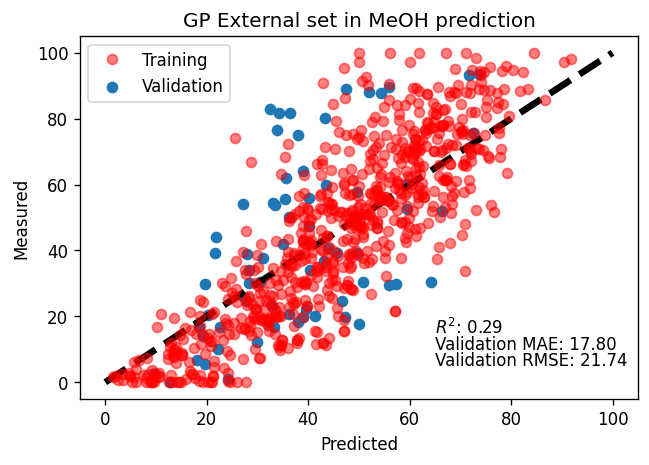

In [16]:
plt.rcParams['figure.dpi'] = 120
fig, ax = plt.subplots()
ax.scatter(pred.mean.numpy()*100,external_y*100,label="Validation")
ax.plot( [0,100],[0,100], 'k--', lw=4)
ax.plot(train_pred.mean.numpy()*100, y_train*100, "or", alpha=0.5, label="Training")
ax.text(65,15,r'$R^2$: {:0.2f}'.format(r2_score(external_y*100,pred.mean.numpy()*100)))
ax.text(65,10,'Validation MAE: {:0.2f}'.format(mean_absolute_error(external_y*100,pred.mean.numpy()*100)))
ax.text(65,5,'Validation RMSE: {:0.2f}'.format(np.sqrt(mean_squared_error(external_y*100,pred.mean.numpy()*100))))
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
ax.set_title('GP External set in MeOH prediction')
plt.legend()
plt.show()

In [17]:
%load_ext watermark

In [18]:
%watermark --iversions

gpytorch  : 1.6.0
seaborn   : 0.11.1
torch     : 1.10.1+cu113
matplotlib: 3.3.3
pandas    : 1.2.0
numpy     : 1.19.2

